In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"husseinslman","key":"6ff9148e7898cf1d73b3a8e03fbe272b"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!unzip -q driver-drowsiness-dataset-ddd.zip


Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown


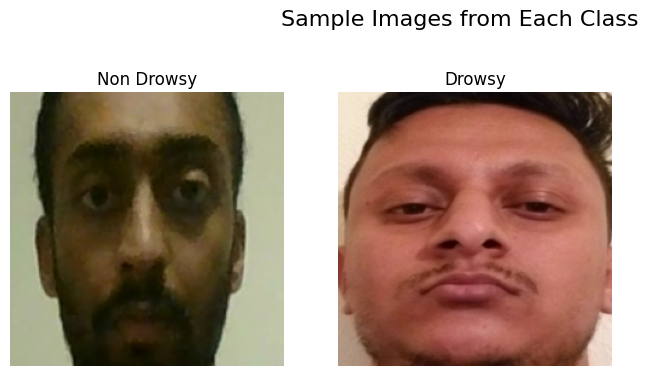

In [3]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Show samples from each class
base_dir = '/content/Driver Drowsiness Dataset (DDD)'
classes = os.listdir(base_dir)

plt.figure(figsize=(12, 8))
for idx, cls in enumerate(classes):
    cls_path = os.path.join(base_dir, cls)
    img_name = random.choice(os.listdir(cls_path))
    img_path = os.path.join(cls_path, img_name)
    img = Image.open(img_path)

    plt.subplot(2, 3, idx+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import Sequence
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from collections import Counter

In [5]:
!pip install split-folders

In [6]:
import splitfolders
data_dir = '/content/Driver Drowsiness Dataset (DDD)'
output_dir = '/content/splitted_Data'

splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

Copying files: 41793 files [00:06, 6015.81 files/s]


In [7]:
train_dir = "/content/splitted_Data/train"
test_dir = "/content/splitted_Data/test"
val_dir = "/content/splitted_Data/val"

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


Pixels of the first image after Normalization: 

[[[0.18823531 0.19215688 0.1764706 ]
  [0.20392159 0.20784315 0.18823531]
  [0.13333334 0.13725491 0.12941177]
  ...
  [0.19215688 0.18431373 0.20000002]
  [0.21960786 0.21176472 0.227451  ]
  [0.20784315 0.20000002 0.21176472]]

 [[0.18431373 0.18823531 0.17254902]
  [0.16470589 0.17254902 0.15294118]
  [0.16078432 0.16470589 0.15686275]
  ...
  [0.21960786 0.21176472 0.227451  ]
  [0.227451   0.21568629 0.23137257]
  [0.21568629 0.20784315 0.21960786]]

 [[0.227451   0.23137257 0.21176472]
  [0.15294118 0.15686275 0.13725491]
  [0.14509805 0.14901961 0.13725491]
  ...
  [0.21960786 0.21176472 0.227451  ]
  [0.21960786 0.21176472 0.227451  ]
  [0.24313727 0.23529413 0.24705884]]

 ...

 [[0.08627451 0.0627451  0.0627451 ]
  [0.09411766 0.07843138 0.06666667]
  [0.21568629 0.13333334 0.09803922]
  ...
  [0.3921569  0.40000004 0.4784314 ]
  [0.38431376 0.3803922  0.46274513]
  [0.36862746 0.3647059  0.4431373 ]]

 [[0.08627451 0.07058824 

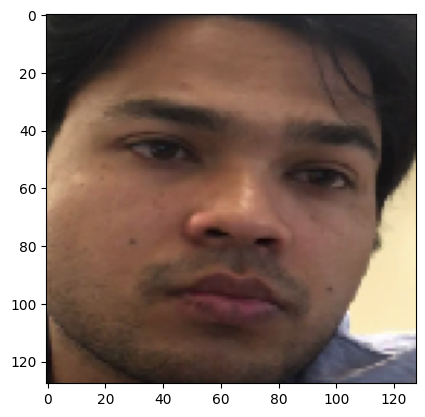

In [10]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[3]}")
plt.imshow(images[3])
plt.show()

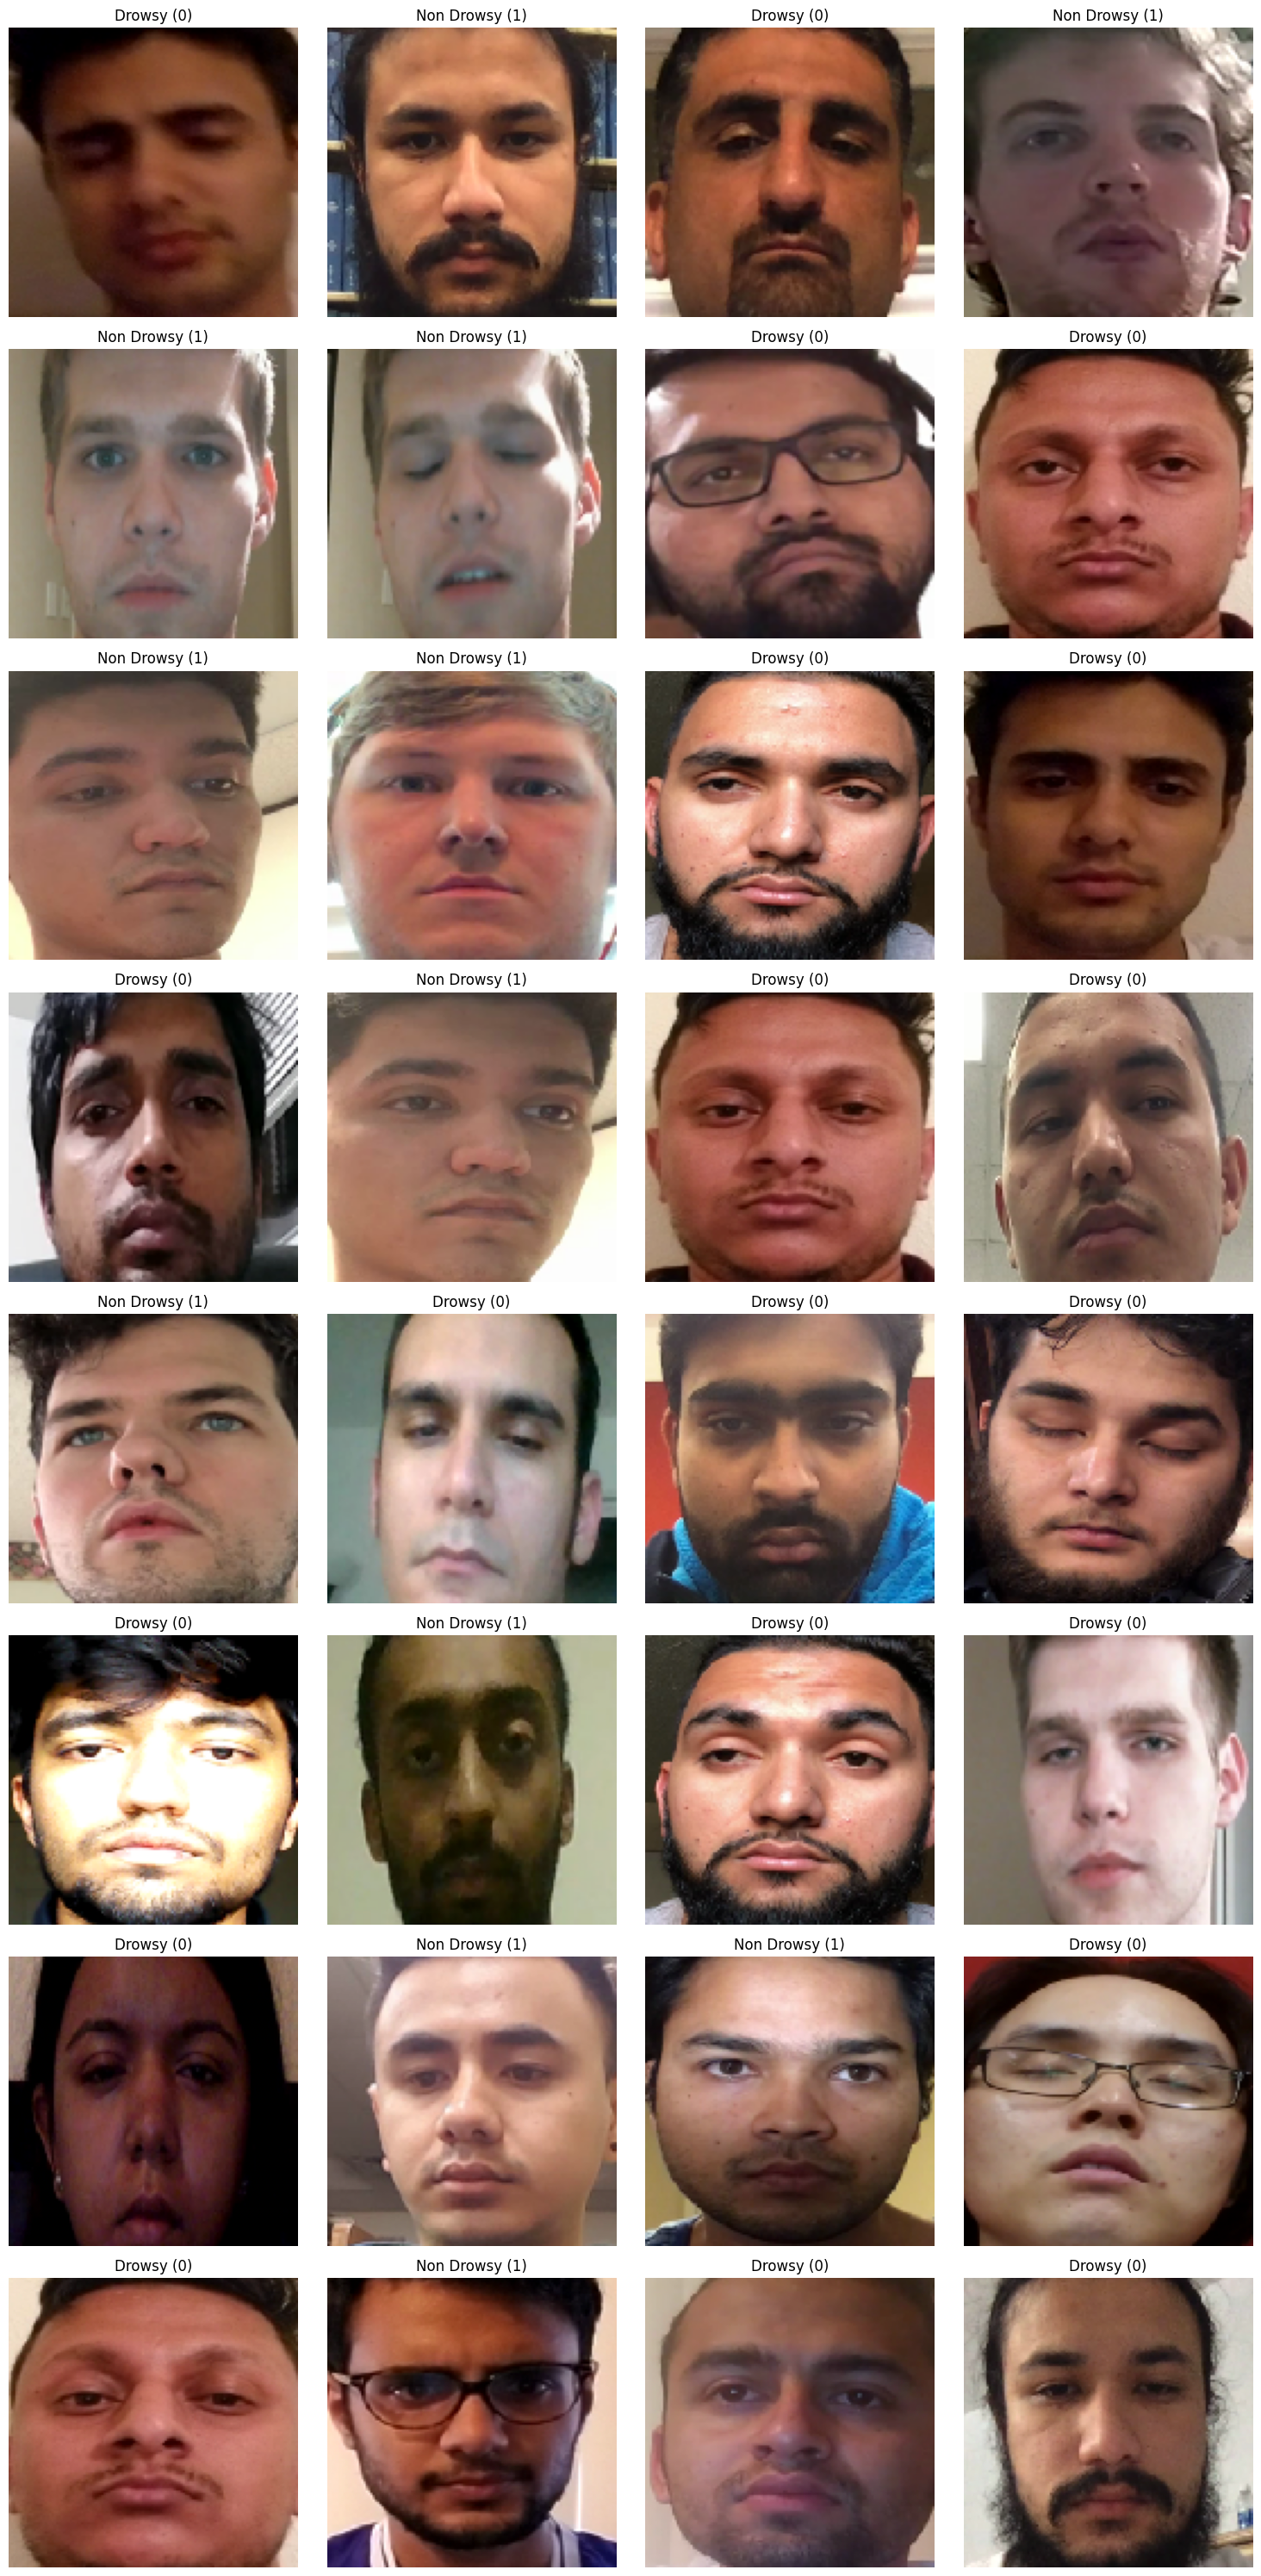

In [11]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):

        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()


**experiment 1**


In [ ]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(16, return_sequences=False),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [ ]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [ ]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.7612 - loss: 0.5053 - val_accuracy: 0.9079 - val_loss: 0.4369
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.7899 - loss: 0.4755 - val_accuracy: 0.9235 - val_loss: 0.4104
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8083 - loss: 0.4446 - val_accuracy: 0.9406 - val_loss: 0.3646
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8196 - loss: 0.4241 - val_accuracy: 0.9493 - val_loss: 0.3316
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.8421 - loss: 0.3941 - val_accuracy: 0.9512 - val_loss: 0.2953
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.8574 - loss: 0.3686 - val_accuracy: 0.9598 - val_loss: 0.2703
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8740 - loss: 0.3386 - val_accuracy: 0.9680 - val_loss: 0.2411
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8883 - loss: 0.3148 - val_accuracy: 0.9742 - v

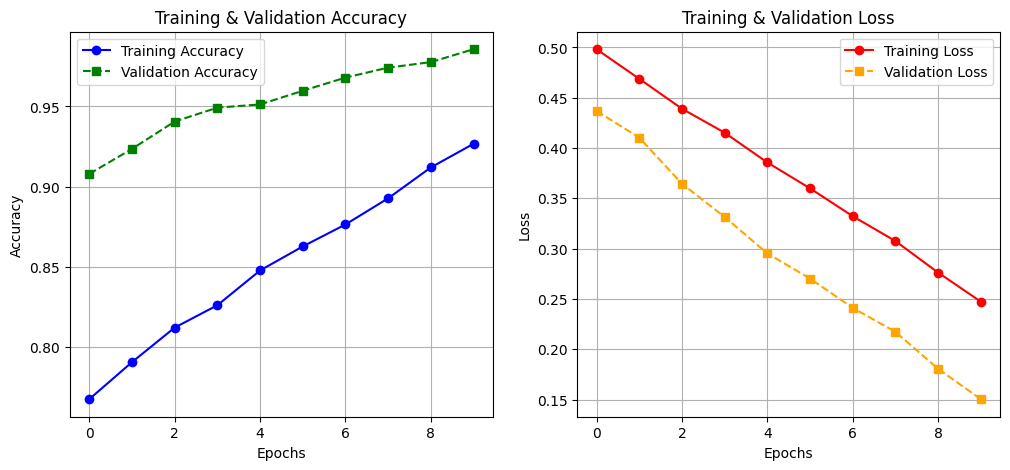

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy", color="blue", marker="o", linestyle="-")
plt.plot(epochs_range, val_acc, label="Validation Accuracy", color="green", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss", color="red", marker="o", linestyle="-")
plt.plot(epochs_range, val_loss, label="Validation Loss", color="orange", marker="s", linestyle="--")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.grid(True)

plt.show()

In [ ]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(16, return_sequences=False),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_16             │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,537 (37.25 KB)

 Trainable params: 9,425 (36.82 KB)

 Non-trainable params: 112 (448.00 B)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [ ]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [ ]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=20
)

KeyboardInterrupt: 

In [ ]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'), input_shape=(5, 128, 128, 3)),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(Conv2D(128, (3,3), activation='relu', padding='same')),
    TimeDistributed(MaxPooling2D((2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(64),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, 5, 128, 128,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 5, 64, 64, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 5, 64, 64, 64)  │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 5, 32, 32, 64)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 5, 32, 32, 128) │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 5, 16, 16, 128) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 5, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,881 (573.75 KB)

 Trainable params: 146,881 (573.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [ ]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=8)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=8)

In [ ]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10
)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 173s 651ms/step - accuracy: 0.5245 - loss: 0.6920 - val_accuracy: 0.5384 - val_loss: 0.6895
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 638ms/step - accuracy: 0.5361 - loss: 0.6902 - val_accuracy: 0.5318 - val_loss: 0.6801
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 169s 644ms/step - accuracy: 0.5837 - loss: 0.6737 - val_accuracy: 0.6810 - val_loss: 0.6252
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 639ms/step - accuracy: 0.6554 - loss: 0.6216 - val_accuracy: 0.7553 - val_loss: 0.5222
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 167s 639ms/step - accuracy: 0.7730 - loss: 0.5208 - val_accuracy: 0.8295 - val_loss: 0.4484
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 168s 642ms/step - accuracy: 0.8503 - loss: 0.4229 - val_accuracy: 0.8852 - val_loss: 0.3481
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 168s 641ms/step - accuracy: 0.8857 - loss: 0.3526 - val_accuracy: 0.9048 - val_loss: 0.3007
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 168s 642ms/step - accuracy: 0.8984 -

In [ ]:
from tensorflow.keras.layers import Bidirectional

model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(5, 128, 128, 3)),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(GlobalAveragePooling2D()),

    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_17             │ (None, 5, 126, 126,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 63, 63, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        49,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,721 (213.75 KB)

 Trainable params: 54,721 (213.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [ ]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=8)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=8)

In [ ]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10
)

Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 592ms/step - accuracy: 0.5296 - loss: 0.6915 - val_accuracy: 0.5374 - val_loss: 0.6901
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 591ms/step - accuracy: 0.5327 - loss: 0.6906 - val_accuracy: 0.5352 - val_loss: 0.6890
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 593ms/step - accuracy: 0.5328 - loss: 0.6894 - val_accuracy: 0.5319 - val_loss: 0.6862
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 153s 584ms/step - accuracy: 0.5480 - loss: 0.6859 - val_accuracy: 0.6100 - val_loss: 0.6807
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 157s 602ms/step - accuracy: 0.5666 - loss: 0.6790 - val_accuracy: 0.6156 - val_loss: 0.6714
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 593ms/step - accuracy: 0.5910 - loss: 0.6716 - val_accuracy: 0.6153 - val_loss: 0.6623
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 155s 593ms/step - accuracy: 0.5997 - loss: 0.6683 - val_accuracy: 0.6276 - val_loss: 0.6533
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 157s 600ms/step - accuracy: 0.6082 -

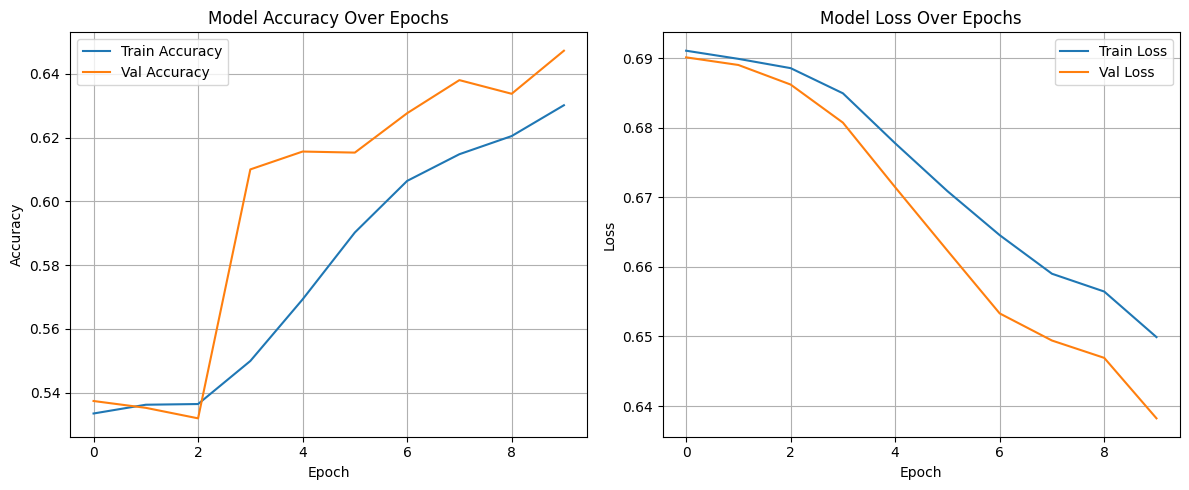

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [27]:
image_size = (128, 128)
sequence_length = 5

model = Sequential([
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same'), input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(48, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(16, return_sequences=False),
    Dropout(0.3),

    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_45             │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_46             │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_47             │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_48             │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_49             │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_50             │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_51             │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_52             │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_53             │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_54             │ (None, 5, 16, 16, 48)  │        13,872 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_55             │ (None, 5, 16, 16, 48)  │           192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 5, 8, 8, 48)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 5, 8, 8, 64)    │        27,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 5, 8, 8, 64)    │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 5, 4, 4, 64)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         5,18

 Total params: 53,617 (209.44 KB)

 Trainable params: 53,281 (208.13 KB)

 Non-trainable params: 336 (1.31 KB)

In [28]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [29]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [30]:
history = model.fit(
    train_seq,
    validation_data=val_seq,
    epochs=10
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 179s 3s/step - accuracy: 0.5506 - loss: 0.6846 - val_accuracy: 0.5323 - val_loss: 0.7559
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.7008 - loss: 0.5784 - val_accuracy: 0.8336 - val_loss: 0.4790
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - accuracy: 0.8057 - loss: 0.4693 - val_accuracy: 0.9565 - val_loss: 0.3162
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8794 - loss: 0.3574 - val_accuracy: 0.9788 - val_loss: 0.2093
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9144 - loss: 0.2785 - val_accuracy: 0.9910 - val_loss: 0.1433
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9426 - loss: 0.2135 - val_accuracy: 0.9974 - val_loss: 0.0952
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9554 - loss: 0.1742 - val_accuracy: 0.9979 - val_loss: 0.0685
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.9620 - loss: 0.1496 - val_accuracy: 0.9974 - v

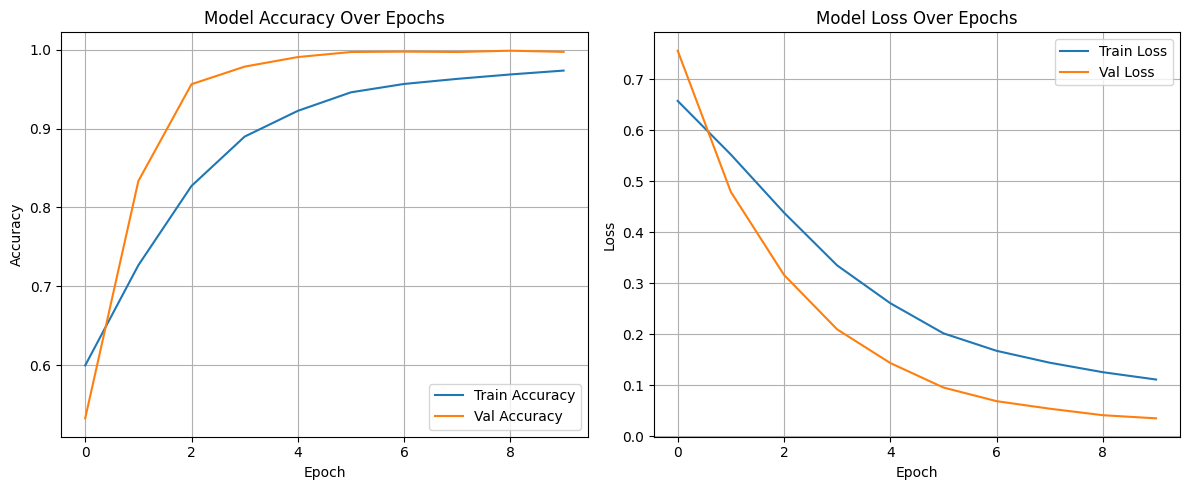

In [31]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, LSTM, Dropout, Dense
)
from tensorflow.keras.regularizers import l2

image_size = (128, 128)
sequence_length = 5

model = Sequential([
    # Block 1
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
                    input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Block 2
    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Block 3
    TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Block 4
    TimeDistributed(Conv2D(48, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Global Pooling
    TimeDistributed(GlobalAveragePooling2D()),

    # Temporal Feature Learning
    LSTM(32, return_sequences=False),
    Dropout(0.5),

    # Fully Connected Layers
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification|\
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_16             │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_17             │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 5, 32, 32, 32)  │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 5, 32, 32, 32)  │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 5, 16, 16, 32)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 5, 16, 16, 48)  │        13,872 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 5, 16, 16, 48)  │           192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 5, 8, 8, 48)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 5, 48)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 31,777 (124.13 KB)

 Trainable params: 31,569 (123.32 KB)

 Non-trainable params: 208 (832.00 B)

In [16]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [17]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=16)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=16)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_seq,
                    validation_data=val_seq,
                    epochs=10,
                    callbacks=[early_stop])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.5573 - loss: 0.7903 - val_accuracy: 0.6612 - val_loss: 0.7334
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.6562 - loss: 0.7226 - val_accuracy: 0.7751 - val_loss: 0.6263
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7585 - loss: 0.6263 - val_accuracy: 0.9145 - val_loss: 0.4312
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.8966 - loss: 0.4391 - val_accuracy: 0.9798 - val_loss: 0.2416
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9559 - loss: 0.2879 - val_accuracy: 0.9859 - val_loss: 0.1697
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9783 - loss: 0.2101 - val_accuracy: 0.9932 - val_loss: 0.1307
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.9872 - loss: 0.1723 - val_accuracy: 0.9945 - val_loss: 0.1201
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.9907 - loss: 0.1504 - val_accu

In [19]:
# Save the model after training
model.save('my_model.keras')  # Saves the model as a .h5 file


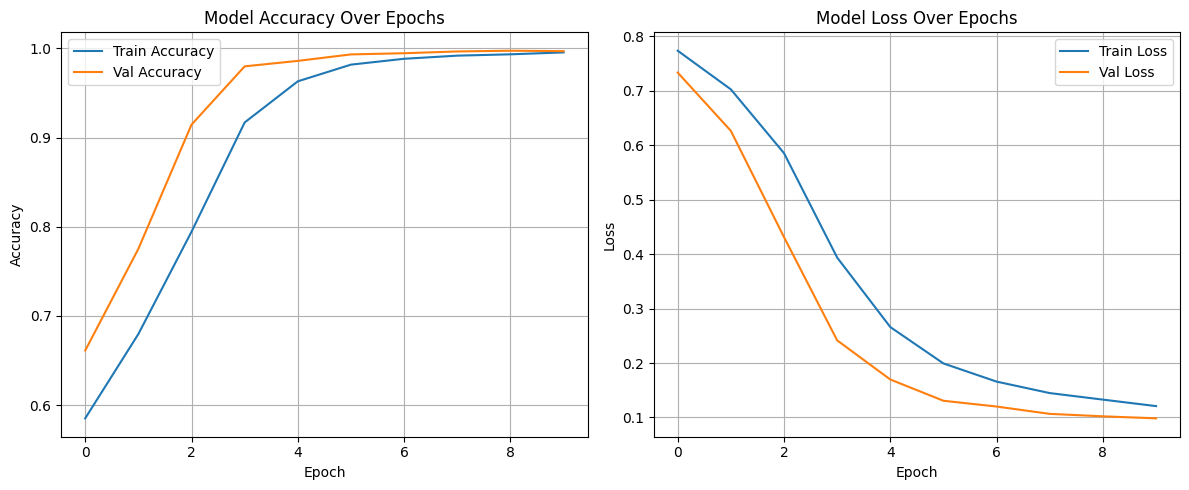

In [20]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


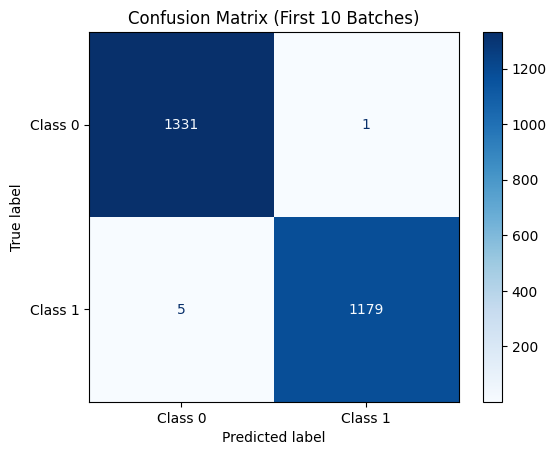

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Set the number of batches you want to evaluate
max_batches = 10  # Change this as needed

# Collect predictions and true labels from limited batches
y_true = []
y_pred = []

for i, (X_batch, y_batch) in enumerate(val_seq):
    # Predict
    preds = model.predict(X_batch)
    preds_labels = (preds > 0.5).astype(int).flatten()

    y_pred.extend(preds_labels)
    y_true.extend(y_batch)

    if i + 1 >= max_batches:
        break

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (First {max_batches} Batches)")
plt.show()


In [22]:
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# === Load Trained Model ===
model = load_model('/content/my_model.keras')

# === Constants ===
sequence_length = 5
frame_size = (128, 128)

# === Video Path ===
video_path = '/content/WhatsApp Video 2025-05-05 at 21.24.42_33d21c99.mp4'
cap = cv2.VideoCapture(video_path)

# === Get original frame size ===
original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# === Output Writer ===
output_path = '/content/predicted_output.avi'
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_path,
                      cv2.VideoWriter_fourcc(*'XVID'),
                      fps,
                      (original_width, original_height))

# === Frame Buffer ===
buffer = deque(maxlen=sequence_length)

# === Process Video ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize to model input
    frame_resized = cv2.resize(frame, frame_size)
    frame_norm = frame_resized.astype('float32') / 255.0
    buffer.append(frame_norm)

    if len(buffer) == sequence_length:
        sequence_input = np.expand_dims(np.array(buffer), axis=0)  # (1, 5, 128, 128, 3)
        prediction = model.predict(sequence_input)[0][0]

        # === Fix if predictions are inverted (like yours) ===
        prediction = 1 - prediction  # Comment this line if model is correct

        label_text = "Drowsy" if prediction > 0.5 else "Not Drowsy"
        confidence = f"{prediction:.2f}"
        full_label = f"{label_text} ({confidence})"

        # Draw on the original frame
        display_frame = frame.copy()
        color = (0, 0, 255) if label_text == "Drowsy" else (0, 255, 0)
        cv2.putText(display_frame, full_label, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
        out.write(display_frame)

cap.release()
out.release()





1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

In [26]:
import cv2

# Path to your video
video_path = '/content/WhatsApp Video 2025-05-05 at 21.24.42_33d21c99.mp4'

# Open the video
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Unable to open video.")
else:
    # Get the width and height of the video
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video width: {width} pixels")
    print(f"Video height: {height} pixels")

# Release the video capture object
cap.release()


Video width: 960 pixels
Video height: 1280 pixels


In [33]:
import cv2
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# === Load Your Trained Model ===
model = load_model('/content/my_model.keras')  # Uncomment if loading from file

# === Constants ===
sequence_length = 5
frame_width = 960  # Adjust to match your video frame width
frame_height = 1280  # Adjust to match your video frame height

# === Video Input Path ===
video_path = '/content/12.mp4'
cap = cv2.VideoCapture(video_path)

# === Output Video Writer ===
output_path = '/content/predicted_output21.avi'
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter(output_path,
                      cv2.VideoWriter_fourcc(*'XVID'),
                      fps,
                      (frame_width, frame_height))

# === Buffer for Sequence Frames ===
buffer = deque(maxlen=sequence_length)

# === Process Video Frames ===
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Normalize the frame (no resizing)
    frame_norm = frame.astype('float32') / 255.0
    buffer.append(frame_norm)

    # Predict only when sequence is full
    if len(buffer) == sequence_length:
        sequence_input = np.expand_dims(np.array(buffer), axis=0)  # (1, 5, 1280, 720, 3)
        prediction = model.predict(sequence_input)[0][0]

        # Reverse the labels: If prediction > 0.5, label as "Not Drowsy", otherwise "Drowsy"
        label_text = "Not Drowsy" if prediction > 0.5 else "Drowsy"
        confidence = f"{prediction:.2f}"
        full_label = f"{label_text} ({confidence})"

        # Annotate the last frame in the sequence
        display_frame = (buffer[-1] * 255).astype(np.uint8).copy()  # Convert back to uint8 for display
        color = (0, 255, 0) if label_text == "Not Drowsy" else (0, 0, 255)
        cv2.putText(display_frame, full_label, (5, 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        out.write(display_frame)  # Write the frame with the label to the output video

# Release resources
cap.release()
out.release()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, LSTM, Dropout, Dense
)
from tensorflow.keras.regularizers import l2

image_size = (128, 128)
sequence_length = 5

model = Sequential([
    # Block 1
    TimeDistributed(Conv2D(8, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
                    input_shape=(sequence_length, image_size[0], image_size[1], 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Block 2
    TimeDistributed(Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),

    # Block 3
    TimeDistributed(Conv2D(48, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.001))),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D(pool_size=(2,2))),


    # Global Pooling
    TimeDistributed(GlobalAveragePooling2D()),

    # Temporal Feature Learning
    LSTM(32, return_sequences=False),
    Dropout(0.5),

    # Fully Connected Layers
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification|\
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']

)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_55             │ (None, 5, 128, 128, 8) │           224 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_56             │ (None, 5, 128, 128, 8) │            32 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 5, 64, 64, 8)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 5, 64, 64, 16)  │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 5, 64, 64, 16)  │            64 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 5, 32, 32, 16)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 5, 32, 32, 48)  │         6,960 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_62             │ (None, 5, 32, 32, 48)  │           192 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_63             │ (None, 5, 16, 16, 48)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_64             │ (None, 5, 48)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,097 (78.50 KB)

 Trainable params: 19,953 (77.94 KB)

 Non-trainable params: 144 (576.00 B)

In [ ]:
class DataGenerator(Sequence):
    def __init__(self, generator, sequence_length, batch_size):
        self.generator = generator
        self.sequence_length = sequence_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.generator) // self.batch_size

    def __getitem__(self, index):
        X_seq, y_seq = [], []
        images, labels = [], []

        for _ in range(self.batch_size):
            batch_images, batch_labels = next(self.generator)
            for img, label in zip(batch_images, batch_labels):
                images.append(img)
                labels.append(label)
                if len(images) == self.sequence_length:
                    X_seq.append(np.array(images))
                    y_seq.append(labels[-1])
                    images.pop(0)

        return np.array(X_seq), np.array(y_seq)

In [ ]:
train_seq = DataGenerator(train_batches, sequence_length=5, batch_size=32)
val_seq = DataGenerator(val_batches, sequence_length=5, batch_size=32)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_seq,
                    validation_data=val_seq,
                    epochs=20,
                    callbacks=[early_stop])


Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.4863 - loss: 0.7819 - val_accuracy: 0.5389 - val_loss: 0.7592
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.5648 - loss: 0.7491 - val_accuracy: 0.6000 - val_loss: 0.7351
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.5988 - loss: 0.7303 - val_accuracy: 0.6165 - val_loss: 0.7113
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.6384 - loss: 0.7044 - val_accuracy: 0.7178 - val_loss: 0.6687
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.6738 - loss: 0.6746 - val_accuracy: 0.7664 - val_loss: 0.6211
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7142 - loss: 0.6330 - val_accuracy: 0.7426 - val_loss: 0.5984
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.7576 - loss: 0.5838 - val_accuracy: 0.8432 - val_loss: 0.4841
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.8115 - loss: 0.5178 - val_accuracy: 0.8450 - v

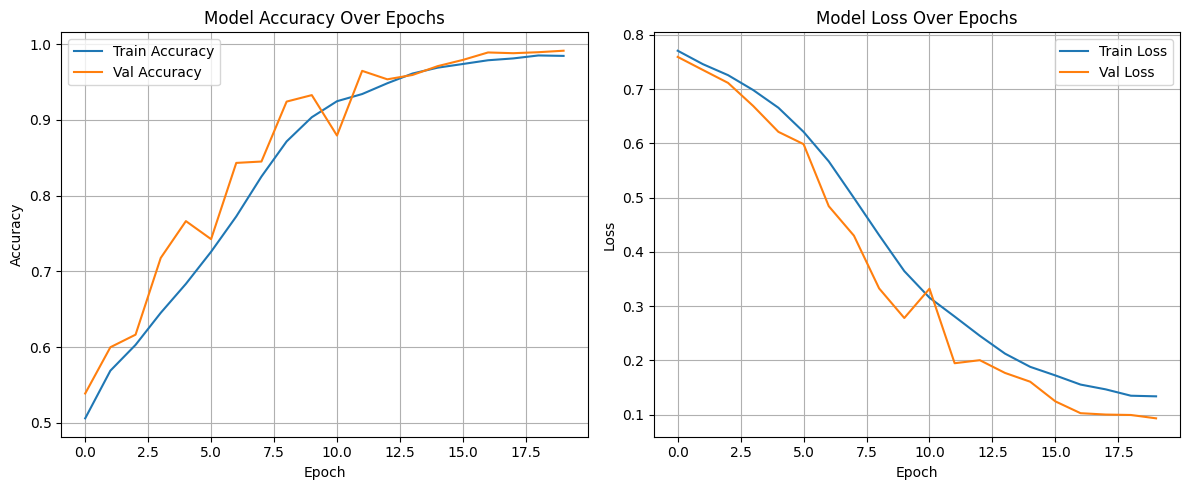

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
